In [1]:
import cv2
import json
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path
from openslide import OpenSlide
from tqdm.notebook import tqdm
%matplotlib inline


r = Path(r'Y:\hpc\dla_patho\premium\pathology\annotations\isala\core')
output_dir = Path(r'Y:\hpc\dla_patho\premium\pathology\hovernet_output\isala\core')
roi_dir = r
slide_r = Path(r'Y:\hpc\dla_patho\premium\pathology\metastasis\isala')

df = pd.DataFrame(columns=['tils_per_area'])

for file in tqdm(sorted(list(r.iterdir()))):
# for file in [r / 'PREM-IS-002_b7fb67d9a5 I2 HE1 - 2022-03-24 19.52.31.json']:
    # print(file.stem)


    # load hovernet output file
    
    try:
        with open(output_dir / (file.stem + '.json'), 'r') as f:
            annotations = json.load(f)
    except Exception as e:
        print(e)
        continue
        
        
    # extract centroids of all TILs
    centroids = []  
    for annotation in annotations:
        if annotation['properties']['classification']['name'] == 'inflam':
            centroid = np.array(annotation['geometry']['coordinates']).mean(axis=-2)[0]
            centroids.append(centroid)

    xx, yy = np.stack(centroids)[:,0], np.stack(centroids)[:,1]

    # load manual roi annotation
    # roi_dir = Path('/home/rens/hpc/PREMIUM histopathology/data_annotations/isala/annotations')
    
    roi_file = roi_dir / (file.stem + '.xml')

    with open(roi_file, 'r') as f:
        xml_file = ET.parse(f)

    # extract all rois
    rois = []
    for annotation in xml_file.getroot()[0]:
        roi = []
        for coordinate in annotation[0]:
            roi.append([coordinate.attrib['X'], coordinate.attrib['Y']])
        rois.append(np.array(roi).astype(float).astype(int))

    # load slide image
    
    slide = OpenSlide(str(slide_r / (file.stem + '.ndpi')))

    img = np.array(slide.read_region((0,0), 4, slide.level_dimensions[4]).convert('RGB'))
    factor = slide.level_dimensions[0][0] / slide.level_dimensions[4][0]

    # plot side by side
    fig, ax = plt.subplots(1,2, figsize=(24,12))
    fig.suptitle(file.stem)
    for roi in rois:
        ax[0].plot(roi[:,0]/factor, roi[:,1]/factor, c='r')
    ax[0].scatter(xx/factor,yy/factor, alpha=1, s=0.1)
    ax[0].set_xlim(0, slide.level_dimensions[4][0])
    ax[0].set_ylim(slide.level_dimensions[4][1], 0)
    ax[1].imshow(img)
    fig.show()

    area = np.zeros((slide.level_dimensions[0][1],slide.level_dimensions[0][0]))
    cv2.fillPoly(area, rois, 1)
    total_area = area.sum() * float(slide.properties['openslide.mpp-x']) * float(slide.properties['openslide.mpp-y']) 
    # print(len(xx) / total_area)

    df.loc[file.stem] = len(xx) / total_area

    break

ModuleNotFoundError: No module named 'openslide'

In [3]:
!pip install opencv-python

    

In [25]:
dmtr = pd.read_csv('/home/rens/repos/PREMIUM/code/radiomics_paper/dmtr.csv').set_index('id')

/home/rens/anaconda3/envs/conda-env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (24,26,111,115,200,204,361,363,470,477,480,521,547,585,591,654) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [28]:
dcb = []
for patient in df.patient:
    dcb.append(dmtr.loc[patient]['dcb'])

TypeError: mannwhitneyu() missing 1 required positional argument: 'y'

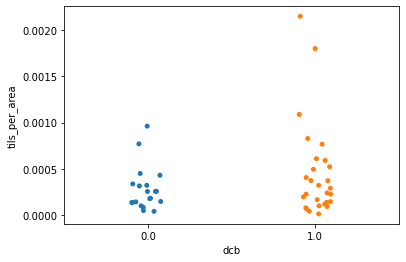

In [32]:
import seaborn as sn
from scipy.stats import mannwhitneyu

df['dcb'] = dcb

sn.stripplot(data=df.dropna(subset=['dcb']), x='dcb', y='tils_per_area')



In [33]:
print(mannwhitneyu(df[df.dcb == 0].tils_per_area, df[df.dcb == 1].tils_per_area))

MannwhitneyuResult(statistic=240.0, pvalue=0.40878724164350344)


In [ ]:
df.to_csv('/home/rens/hpc/rens/output/isala_tils_per_area.csv')

In [10]:
43507/180480

0.24106272163120568